In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler

In [5]:
data = pd.read_csv("./local_data/df_final_scaled.csv")
data = data.sort_values("price", ascending=True).tail(3080)

In [6]:
numerical_data = data.filter(data.select_dtypes(["float64", "int64"]).columns)
numerical_data = numerical_data.fillna(numerical_data.median()).dropna(axis=1)
drop_cols = [
    "id",
    "host_id",
    "name",
    "neighbourhood_group",
    "neighbourhood",
    "last_review",
    "scrape_id",
    "price_per_person",
]
numerical_data = numerical_data.drop(columns=drop_cols, errors="ignore")
# numerical_data = numerical_data[
#     numerical_data["price"] < numerical_data["price"].quantile(0.99)
# ]

In [7]:
def transform_features(df: pd.DataFrame) -> pd.DataFrame:
    transformed_df = df.copy()

    numeric_cols = df.select_dtypes(include=["float64", "int64"]).columns.tolist()
    if "price" in numeric_cols:
        numeric_cols.remove("price")

    sqrt_df = df[numeric_cols].apply(lambda x: np.sqrt(x - x.min() + 1))
    sqrt_df.columns = [f"sqrt_{col}" for col in numeric_cols]

    log_df = df[numeric_cols].apply(lambda x: np.log(x - x.min() + 1))
    log_df.columns = [f"log_{col}" for col in numeric_cols]

    # winsorisation
    wins_df = df[numeric_cols].apply(
        lambda x: stats.mstats.winsorize(x, limits=[0.023, 0.023])
    )
    wins_df.columns = [f"wins_{col}" for col in numeric_cols]

    return pd.concat([transformed_df, sqrt_df, log_df, wins_df], axis=1)


numerical_data_transformed = transform_features(numerical_data)

In [8]:
X = numerical_data_transformed.drop("price", axis=1)
y = numerical_data["price"]

In [9]:
numerical_data_transformed.sort_values("price", ascending=False).head(20)

,host_response_rate,host_acceptance_rate,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,...,wins_tourism_sportsactivitylocation,wins_tourism_store,wins_tourism_touristattraction,wins_tourism_winery,wins_tourism_zoo,wins_tourism_total,wins_tourism_points_within_radius,wins_noise_day,wins_noise_night,wins_noise_points_within_radius
1983,-1.911719,0.544685,-1.024634,-0.514149,-0.900460,-0.164740,-1.857607,-0.332158,-0.157039,-0.416623,...,1.074471,-0.744015,-0.670749,0.0,2.947169,0.215881,0.709644,-1.752516,-1.710399,0.018019
1346,-1.594666,0.972546,0.451376,0.105740,-0.301757,0.342559,1.676828,1.968991,1.998322,1.420568,...,1.632417,1.199928,1.797956,0.0,2.909945,1.653514,1.469236,0.238603,0.235092,0.018019
2508,-1.911301,-1.621456,-0.169530,0.271007,-0.406207,0.388183,1.004068,-2.910684,1.097222,-0.416623,...,1.639471,1.253458,1.797956,0.0,2.945991,1.662286,1.469236,1.793658,1.908625,0.018019
1347,-1.594666,0.972546,0.451376,0.105740,-0.301757,0.342559,1.676828,1.968991,1.998322,1.420568,...,1.632417,1.199928,1.797956,0.0,2.909945,1.653514,1.469236,0.238603,0.235092,0.018019
1343,-1.594666,0.972546,0.451376,0.105740,-0.301757,0.342559,1.676828,1.968991,1.998322,1.420568,...,1.632417,1.199928,1.797956,0.0,2.909945,1.653514,1.469236,0.238603,0.235092,0.018019
1945,0.634417,0.972546,0.451376,0.105740,-1.881367,-0.030686,2.381287,3.383867,3.292537,2.298203,...,1.554887,-0.790355,-0.790133,0.0,-0.461888,-1.056371,-0.974518,-0.798758,-0.728294,0.018019
1036,-1.804746,-0.759836,0.776204,0.488081,-0.581842,0.358342,1.676828,3.383867,3.292537,-2.811138,...,1.660876,0.028223,1.797894,0.0,2.947169,1.510867,1.455910,0.416514,0.537111,0.018019
899,0.634417,0.544685,-1.024634,-1.216334,-0.933841,0.714243,1.004068,-0.332158,-0.157039,-0.416623,...,1.452598,1.633692,1.691811,0.0,2.020116,1.239162,1.049025,0.956689,1.056466,0.018019
891,-1.409635,0.972546,1.154523,1.096450,-0.969914,-0.420063,2.092994,3.383867,-0.157039,1.918964,...,1.618644,-0.776615,-0.789322,0.0,1.412402,-0.310375,-0.045611,1.185200,1.282143,0.018019
1078,0.634417,0.750082,0.928859,0.682340,-0.881944,0.690996,1.906143,1.079447,1.998322,1.420568,...,1.615867,1.645992,1.777759,0.0,2.498143,1.386168,1.121788,-0.116231,-0.076249,0.018019


In [10]:
y.describe()

count    3080.000000
mean        0.001290
std         0.997758
min        -3.850241
25%        -0.577247
50%         0.001519
75%         0.610090
max         4.472673
Name: price, dtype: float64

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=99
)


# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

X_train_scaled = X_train
X_test_scaled = X_test

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

In [12]:
cv = KFold(n_splits=5, shuffle=True, random_state=99)

In [13]:
lasso_cv = LassoCV(
    cv=cv,
    random_state=99,
    max_iter=100000,
    alphas=np.logspace(-2, 3, 100),
    selection="random",
    tol=1e-3,
    fit_intercept=True,
)

lasso_cv.fit(X_train_scaled, y_train)

LassoCV(alphas=array([1.00000000e-02, 1.12332403e-02, 1.26185688e-02, 1.41747416e-02,
       1.59228279e-02, 1.78864953e-02, 2.00923300e-02, 2.25701972e-02,
       2.53536449e-02, 2.84803587e-02, 3.19926714e-02, 3.59381366e-02,
       4.03701726e-02, 4.53487851e-02, 5.09413801e-02, 5.72236766e-02,
       6.42807312e-02, 7.22080902e-02, 8.11130831e-02, 9.11162756e-02,
       1.02353102e-01, 1.14975700e-0...
       1.74752840e+02, 1.96304065e+02, 2.20513074e+02, 2.47707636e+02,
       2.78255940e+02, 3.12571585e+02, 3.51119173e+02, 3.94420606e+02,
       4.43062146e+02, 4.97702356e+02, 5.59081018e+02, 6.28029144e+02,
       7.05480231e+02, 7.92482898e+02, 8.90215085e+02, 1.00000000e+03]),
        cv=KFold(n_splits=5, random_state=99, shuffle=True), max_iter=100000,
        random_state=99, selection='random', tol=0.001)

Best regularization parameter: 0.01


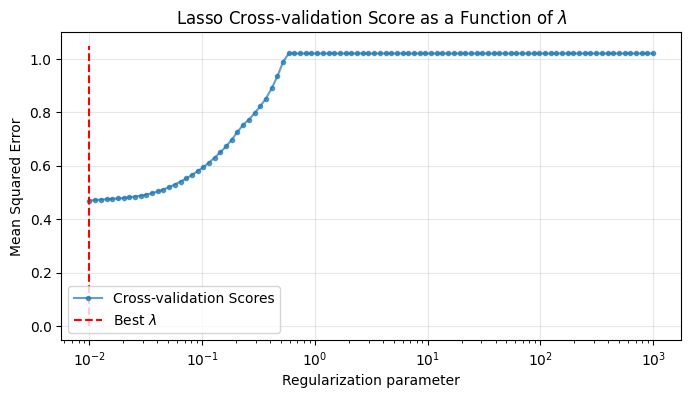

In [14]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(
    lasso_cv.alphas_,
    lasso_cv.mse_path_.mean(axis=1),
    marker="o",
    markersize=3,
    alpha=0.7,
    label="Cross-validation Scores",
)
# Plot the final chosen regularization parameter
ax.vlines(
    lasso_cv.alpha_,
    0,
    ax.get_ylim()[1],
    linestyle="--",
    color="red",
    label=r"Best $\lambda$",
)

# Aesthetics
ax.set_xscale("log")
ax.set_xlabel("Regularization parameter")
ax.set_ylabel("Mean Squared Error")
ax.set_title(r"Lasso Cross-validation Score as a Function of $\lambda$")
ax.grid(alpha=0.3)
ax.legend()

print(f"Best regularization parameter: {lasso_cv.alpha_:.2f}")

In [15]:
def evaluate_model(y_true: np.ndarray, y_pred: np.ndarray, dataset_name: str) -> None:
    """"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n{dataset_name} Metrics:")
    print(f"R² Score: {r2:.4f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")


y_train_pred = lasso_cv.predict(X_train_scaled)
y_test_pred = lasso_cv.predict(X_test_scaled)


evaluate_model(y_train, y_train_pred, "train")
evaluate_model(y_test, y_test_pred, "test")


train Metrics:
R² Score: 0.5901
RMSE: 0.65
MAE: 0.48

test Metrics:
R² Score: 0.5475
RMSE: 0.66
MAE: 0.49


\coeffs:
                                                  feat     coeff
6                                         accommodates  0.300402
16                              minimum_nights_avg_ntm -0.211793
8                                             bedrooms  0.116595
22                                   number_of_reviews -0.115590
21                                    availability_365  0.100176
368                 log_tourism_sportsactivitylocation  0.089925
266                         log_minimum_maximum_nights  0.081861
385                                     wins_bathrooms  0.079584
279                      log_review_scores_cleanliness  0.078170
393                        wins_maximum_maximum_nights -0.076430
9                                                 beds  0.072514
417                        wins_days_since_last_review -0.065554
124                                        noise_night  0.063554
409                           wins_review_scores_value -0.056882
19              

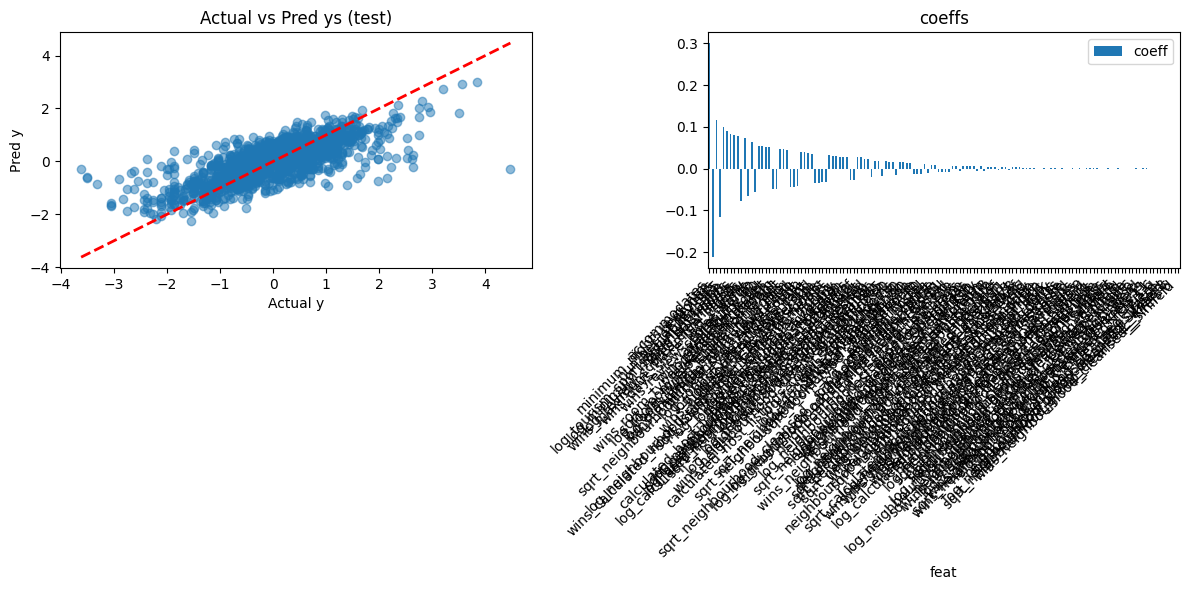

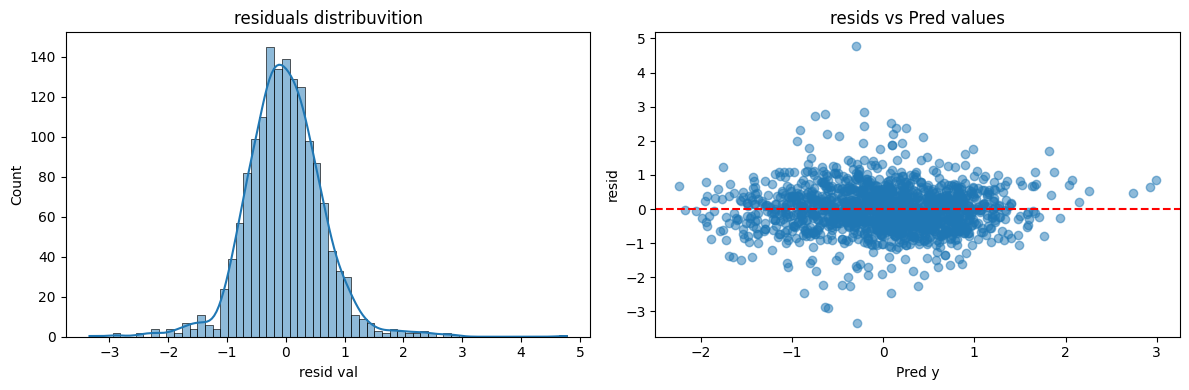

In [16]:
feature_importance = pd.DataFrame({"feat": X.columns, "coeff": lasso_cv.coef_})

feature_importance["Abs_coeff"] = abs(feature_importance["coeff"])
feature_importance_sorted = feature_importance.sort_values("Abs_coeff", ascending=False)
non_zero_features = feature_importance_sorted[feature_importance_sorted["coeff"] != 0]

print(r"\coeffs:")
print(non_zero_features[["feat", "coeff"]].to_string())

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", lw=2)
plt.xlabel("Actual y")
plt.ylabel("Pred y")
plt.title("Actual vs Pred ys (test)")

# Plot 2: feat coeffs
plt.subplot(1, 2, 2)
non_zero_features.plot(kind="bar", x="feat", y="coeff", ax=plt.gca())
plt.xticks(rotation=45, ha="right")
plt.title("coeffs")
plt.tight_layout()
plt.show()

residuals = y_test - y_test_pred

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True)
plt.title("residuals distribuvition")
plt.xlabel("resid val")

plt.subplot(1, 2, 2)
plt.scatter(y_test_pred, residuals, alpha=0.5)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Pred y")
plt.ylabel("resid")
plt.title("resids vs Pred values")
plt.tight_layout()
plt.show()

In [17]:
coefficient_df = pd.DataFrame(
    {
        "feature": X.columns,
        "coeff": lasso_cv.coef_,
        "coeff_abs": abs(lasso_cv.coef_),
    }
)

coefficient_df = coefficient_df.sort_values("coeff_abs", ascending=False)
coefficient_df

,feature,coeff,coeff_abs
6,accommodates,0.300402,0.300402
16,minimum_nights_avg_ntm,-0.211793,0.211793
8,bedrooms,0.116595,0.116595
22,number_of_reviews,-0.115590,0.115590
21,availability_365,0.100176,0.100176
...,...,...,...
185,sqrt_neighbourhood_cleansed__Enge,-0.000000,0.000000
183,sqrt_neighbourhood_cleansed__Altstetten,0.000000,0.000000
182,sqrt_neighbourhood_cleansed__Alt-Wiedikon,0.000000,0.000000
179,sqrt_neighbourhood_group_cleansed__Kreis 9,-0.000000,0.000000


## RF


In [18]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor


def perform_rf(X_train_scaled, y_train):
    rf = RandomForestRegressor(
        n_estimators=300,
        random_state=99,
        max_depth=15,
        min_samples_split=10,
        min_samples_leaf=5,
    )

    rf.fit(X_train_scaled, y_train)

    return rf


def evaluate_rf(rf, y_true, y_pred, dataset_name: str):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"{dataset_name} Metrics:")
    print(f"R² Score: {r2:.4f}")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")

    feature_importance = pd.DataFrame(
        {"feature": X.columns, "importance": rf.feature_importances_}
    ).sort_values("importance", ascending=False)

    return mse, rmse, mae, r2, feature_importance


def visualize_rf_performance(y_true, y_pred, feature_importance):
    fig, axes = plt.subplots(1, 2, figsize=(16, 12))

    # Scatter, actual vs predicted
    axes[0, 0].scatter(y_true, y_pred, alpha=0.5)
    axes[0, 0].plot(
        [y_true.min(), y_true.max()], [y_true.min(), y_true.max()], "r--", lw=2
    )
    axes[0, 0].set_title("Actual vs Predicted Values")
    axes[0, 0].set_xlabel("Actual Values")
    axes[0, 0].set_ylabel("Predicted Values")

    # feature_importance bar chart (top 10)
    top_features = feature_importance.head(10)
    sns.barplot(x="importance", y="feature", data=top_features, ax=axes[1, 0])
    axes[0, 1].set_title("Top 10 Most Important Features")
    axes[0, 1].set_xlabel("Feature Importance")

    plt.tight_layout()
    plt.show()

In [19]:
# Random forest

perform_rf(X_train_scaled, y_train)  # fit random forest model

y_train_pred_rf = rf.predict(X_train_scaled)  # make predictions
y_test_pred_rf = rf.predict(X_test_scaled)

evaluate_rf(
    rf, y_train, y_train_pred_rf, "train"
)  # evaluate with MSE etc. and show most important features
evaluate_rf(rf, y_test, y_test_pred_rf, "test")

visualize_rf_performance(
    y_train, y_train_pred_rf, feature_importance
)  # create scatter plot with actual vs predicted data, plot bar chart with most important features, or use Y_TEST_PRED_RF TO VISUALISE